In [273]:
######## Import of necessary packages ########
# CountVectorizer for creating the BoW matrix
from sklearn.feature_extraction.text import CountVectorizer

# Cross validation for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

# Pandas for dataset preparation
import pandas as pd

# GaussianNB as Naive Bayes implementation for model
from sklearn.naive_bayes import GaussianNB

import re

# Import stopwords word_tokenize from Natural Language Toolkit for cleaning the text columns of the dataset and splitting sentences into single words
import nltk
from nltk.corpus import stopwords
##############################################


# Definition of column names of the dataset
from sklearn.preprocessing import MinMaxScaler

columnname_account = 'Auftragskonto'
columnname_orderdate = 'Buchungstag'
columnname_valutadate = 'Valutadatum'
columnname_usage = 'Verwendungszweck'
columnname_text = 'Buchungstext'
columnname_target_sender = 'Beguenstigter/Zahlungspflichtiger'
columnname_depotnumber = 'Kontonummer'
columnname_blz = 'BLZ'
columnname_amount = 'Betrag'
columnname_currency = 'Waehrung'
columnname_label = 'label'

# Definition of the the column names for the training dataframe
columnname_final_messages = 'messages'
columnname_final_class = 'class'

dataset_file = "dataset.csv"
dataset_separator = ";"

# Percentage of the training set size based on the dataset size
training_set_size = 0.8

nltk.download('punkt')
nltk.download('stopwords')

# Set displayed rows
pd.set_option('display.max_rows', 10)

general_bag_of_words = list()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jande\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Load

In [274]:
data = pd.read_csv(dataset_file, sep=dataset_separator)
print("Complete dataset size: " +str(len(data)))

Complete dataset size: 209


## Raw Data Shape

In [275]:
print("####################### Raw Data #######################")
data_raw_summary = pd.DataFrame(data.dtypes)
data_raw_statistics = data.describe().transpose()
data_raw_summary["Null Values"] = data.isnull().sum()
data_raw_summary = pd.concat([data_raw_summary,data_raw_statistics], axis=1)
print(data_raw_summary)

####################### Raw Data #######################
                     0  Null Values  count          mean        std  \
Unnamed: 0       int64            0  209.0  1.040000e+02  60.477268   
Auftragskonto  float64           41  168.0  8.999021e+07   4.077940   
Buchungstag     object            0    NaN           NaN        NaN   
Valutadatum     object            0    NaN           NaN        NaN   
Buchungstext    object            0    NaN           NaN        NaN   
...                ...          ...    ...           ...        ...   
Kontonummer     object            1    NaN           NaN        NaN   
BLZ             object            1    NaN           NaN        NaN   
Betrag          object            0    NaN           NaN        NaN   
Waehrung        object            0    NaN           NaN        NaN   
label           object            0    NaN           NaN        NaN   

                      min         25%         50%         75%         max  
Unnamed: 0    

## Data Preparation

In [276]:
def removePunctuationAndSpecialCharacters(text):
    return text.replace('.', '').replace('&', '').replace(':', '').replace('/', ' ').replace('-',' ')

def removeSpecialWords(text):
    # Remove End-to-End-Ref
    text = text.replace('end-to-end-ref', ' ')
    # Remove NotProvided
    text = text.replace('notprovided ', ' ')
    # Remove NSCT numbers via regex
    text = re.sub(r'nsct\d*', ' ', text)
    return text

# Remove unnecessary text contents like punctuation, stopwords and text with no valuable information
def transform_text(text):
    text = text.lower()
    text = removePunctuationAndSpecialCharacters(text)
    text = removeSpecialWords(text)
    words = nltk.word_tokenize(text, language="german")
    for word in words:
        if word in stopwords.words('german'):
            words.remove(word)
        if word not in general_bag_of_words:
            general_bag_of_words.append(word)
    return " ".join(words)

# Vectorize a given text and count the occurence of words
def vectorize(prepared_text):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(prepared_text).toarray()
    topics = vectorizer.get_feature_names()
    return pd.DataFrame(data=X, columns=topics)

# Prepare basic data
def prepare_data (dataset):
    print("Preparing data...")
    prepared = dataset
    prepared = prepared.fillna(0) # Fill NULL values with 0

    #Transform columns to numerical values
    prepared[columnname_account] = dataset[columnname_account].astype('category')
    prepared[columnname_account] = prepared[columnname_account].cat.codes

    prepared[columnname_blz] = dataset[columnname_blz].astype('category')
    prepared[columnname_blz] = prepared[columnname_blz].cat.codes

    prepared[columnname_text] = dataset[columnname_text].astype('category')
    prepared[columnname_text] = prepared[columnname_text].cat.codes

    prepared[columnname_depotnumber] = dataset[columnname_depotnumber].astype('category')
    prepared[columnname_depotnumber] = prepared[columnname_depotnumber].cat.codes

    prepared[columnname_currency] = dataset[columnname_currency].astype('category')
    prepared[columnname_currency] = prepared[columnname_currency].cat.codes

    prepared[columnname_orderdate] = pd.to_datetime(prepared[columnname_orderdate])
    prepared[columnname_valutadate] = pd.to_datetime(prepared[columnname_valutadate])

    # Normalize the "Betrag" feature via MinMax
    prepared[columnname_amount] = prepared[columnname_amount].str.replace(',','.')
    prepared[columnname_amount] = prepared[columnname_amount].astype('float')
    mm_scaler = MinMaxScaler(feature_range=(0, 1))
    prepared[columnname_amount] = mm_scaler.fit_transform(prepared[[columnname_amount]].values)

    return prepared

# Prepare the text features
def prepare_text_data(dataset):
    print("Preparing text featues...")
    usage = dataset[columnname_usage].apply(transform_text)
    target_sender = dataset[columnname_target_sender].apply(transform_text)

    dataframe_usage = vectorize(usage)
    dataframe_targetsender = vectorize(target_sender)

    return pd.concat([dataframe_usage, dataframe_targetsender], axis=1)

# This will produce a complete prepared dataframe which can be used for training or also for prediction
def run_complete_prepare(dataset):
    print("Starting preparation of data...")
    prepared_data = prepare_data(dataset)
    text_data = prepare_text_data(prepared_data)

    # Remove text features as we use the results from the count vectorizer, also the Id is not required
    prepared_data = prepared_data.drop(["Unnamed: 0", columnname_usage, columnname_target_sender], axis=1)

    final_Data = pd.concat([prepared_data, text_data], axis=1)
    final_Data = final_Data.loc[:,~final_Data.columns.duplicated()] # Remove duplicates from dataset
    print("Prepared data!")
    return final_Data

data_final = run_complete_prepare(data)

Starting preparation of data...
Preparing data...
Preparing text featues...
Prepared data!


## Prepared Data Statistics

In [277]:
######## Used for statistics ########
data_prepared = prepare_data(data)
data_text = prepare_text_data(data_prepared)
# Remove text features as we use the results from the count vectorizer, also the Id is not required
data_prepared = data_prepared.drop(["Unnamed: 0", columnname_usage, columnname_target_sender], axis=1)
#####################################

print("\n#################### Prepared Data #####################")
data_prepared_summary = pd.DataFrame(data_prepared.dtypes)
data_prepared_statistics = data_prepared.describe().transpose()
data_prepared_summary["Null Values"] = data_prepared.isnull().sum()
data_prepared_summary = pd.concat([data_prepared_summary,data_prepared_statistics], axis=1)
print(data_prepared_summary)

print("\n################### Text Statistics ####################")
data_text_summary = pd.DataFrame(data_text.dtypes)
data_text_statistics = data_text.describe().transpose()
data_text_summary["Null Values"] = data_text.isnull().sum()
data_text_summary = pd.concat([data_text_summary,data_text_statistics], axis=1)
print(data_text_summary)

print("\n##################### Overall BoW ######################")
print("Length of Bow: ", len(general_bag_of_words))
print(general_bag_of_words)

Preparing data...
Preparing text featues...

#################### Prepared Data #####################
                            0  Null Values  count       mean        std  min  \
Auftragskonto            int8            0  209.0   0.377990   0.794024 -1.0   
Buchungstag    datetime64[ns]            0    NaN        NaN        NaN  NaN   
Valutadatum    datetime64[ns]            0    NaN        NaN        NaN  NaN   
Buchungstext             int8            0  209.0   7.406699   2.784254  0.0   
Kontonummer              int8            0  209.0  17.464115  16.175715 -1.0   
BLZ                      int8            0  209.0  15.622010  14.501183 -1.0   
Betrag                float64            0  209.0   0.626572   0.102435  0.0   
Waehrung                 int8            0  209.0   0.000000   0.000000  0.0   
label                  object            0    NaN        NaN        NaN  NaN   

                    25%        50%        75%   max  
Auftragskonto  0.000000   1.000000   1.0000

# Feature Selection

In [278]:
selected_features = data_final.drop([columnname_label, columnname_orderdate, columnname_valutadate], axis=1)
selected_features_labels = data_final[columnname_label]
train_data, test_data, train_labels, test_labels = train_test_split(selected_features, selected_features_labels, test_size=1-training_set_size, random_state=345)

print("Training|Test Size: " +str(len(train_data)) + "|"+str(len(test_data)))

Training|Test Size: 167|42


# Naive Gaussian Classification
## Training

In [279]:
gnb_model = GaussianNB()
gnb_model.fit(train_data, train_labels)

GaussianNB()

## Evaluation
### Accuracy and Class Precision

In [285]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

test_prediction = gnb_model.predict(test_data)

accuracy = metrics.accuracy_score(test_labels,test_prediction)
null_accuracy =12/len(test_labels)

print("Accuracy:            ", accuracy)
print("Null Accuracy:       ", null_accuracy)
print("\n")
print("Classification Report:   \n", metrics.classification_report(test_labels,test_prediction))

cross_val_sc = cross_val_score(gnb_model, test_data, test_labels, cv=4)
print("Cross Validation Mean: ", cross_val_sc.mean())

Accuracy:             0.9285714285714286
Null Accuracy:        0.2857142857142857


Classification Report:   
                   precision    recall  f1-score   support

         finance       1.00      1.00      1.00         5
          income       1.00      1.00      1.00         6
         leisure       0.92      0.92      0.92        12
          living       0.75      0.75      0.75         4
         private       1.00      1.00      1.00         4
standardOfLiving       0.91      0.91      0.91        11

        accuracy                           0.93        42
       macro avg       0.93      0.93      0.93        42
    weighted avg       0.93      0.93      0.93        42

Cross Validation Mean:  0.7863636363636364


### Confusion Matrix

In [281]:
confusion_matrix_frame = pd.crosstab(test_labels, test_prediction, rownames=['Actual'], colnames=['Predicted'])

def true_positives(matrix):
    tp = 0
    for i in range(6):
        tp += matrix[i,i]
    return tp

def false_positives(matrix):
    fp = 0
    for i in range(6):
        for y in range( i+1, 6, 1):
            fp += matrix[i,y]
    return fp

def false_negatives(matrix):
    fn = 0
    for i in range(6):
        for y in range( 0, i, 1):
            fn += matrix[i,y]
    return fn

tmp_confusion_matrix = confusion_matrix(test_labels, test_prediction)

tps = true_positives(tmp_confusion_matrix)
fps = false_positives(tmp_confusion_matrix)
fns = false_negatives(tmp_confusion_matrix)

print("\nTrue Positives: " +str(tps))
print("False Positives: " +str(fps))
print("True Negatives: " +str(fns))

classification_error = (fns +fps) / float(len(test_labels))
print("\nClassification Error: ", classification_error)


True Positives: 39
False Positives: 2
True Negatives: 1

Classification Error:  0.07142857142857142


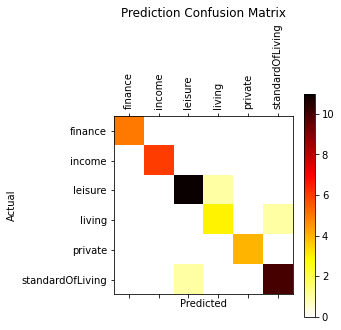

In [282]:
def plot_confusion_matrix(df_confusion, title='Prediction Confusion Matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=90)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(confusion_matrix_frame,cmap=plt.cm.hot_r)

In [283]:
print("Confusion Matrix with values:   \n", confusion_matrix_frame)

Confusion Matrix with values:   
 Predicted         finance  income  leisure  living  private  standardOfLiving
Actual                                                                       
finance                 5       0        0       0        0                 0
income                  0       6        0       0        0                 0
leisure                 0       0       11       1        0                 0
living                  0       0        0       3        0                 1
private                 0       0        0       0        4                 0
standardOfLiving        0       0        1       0        0                10


### Prediction Probability Distribution

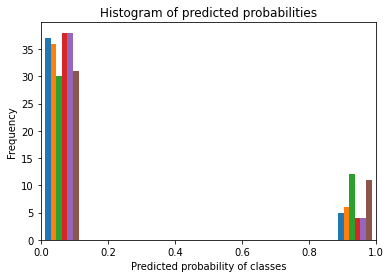

In [284]:
def plot_dis(class_proba):
    plt.hist(class_proba, bins=8)
    # x-axis limit from 0 to 1
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of classes')
    plt.ylabel('Frequency')

plot_dis(gnb_model.predict_proba(test_data))